# 0. Initialize

In [1]:
import librosa
import os
from helper_code import *
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats import ttest_ind
import seaborn as sns
import statsmodels
import numpy as np
import pandas as pd
from ast import literal_eval

from team_code import get_features, get_outcome

/Users/felixkrones/.local/share/virtualenvs/physionet_challenge_2023-6KmQCTHE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_folder = "/Users/felixkrones/python_projects/data/physionet_challenge_2023/physionet.org/files/i-care/2.0/training"
data_folder = "/Users/felixkrones/python_projects/data/physionet_challenge_2023/physionet.org/files/i-care/2.0/test_test"
output_dir = "/Users/felixkrones/python_projects/data/physionet_challenge_2023/preprocessed_data/"

In [3]:
# Check if output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 1. Get and prep data

In [4]:
patient_ids = find_data_folders(data_folder)
num_patients = len(patient_ids)

if num_patients==0:
    raise FileNotFoundError('No data was provided.')

features = list()
recordings = list()
outcomes = list()
cpcs = list()
for i in tqdm(range(num_patients)):
    # Load data.
    patient_id = patient_ids[i]
    patient_metadata = load_challenge_data(data_folder, patient_id)
    recording_ids = find_recording_files(data_folder, patient_id)
    #recording_metadata_file = os.path.join(data_folder, patient_id, patient_id + '.tsv')
    #recording_metadata = load_text_file(recording_metadata_file)
    #hours = get_variable(recording_metadata, 'Hour', str)
    #times = get_variable(recording_metadata, 'Time', str)
    #qualities = get_variable(recording_metadata, 'Quality', str)
    recordings_data_eeg = list()
    #recordings_data_ecg = list()
    for recording_id in recording_ids:
        if not is_nan(recording_id):
            recording_location_eeg = os.path.join(data_folder, patient_id, '{}_{}'.format(recording_id, "eeg"))
            #recording_location_ecg = os.path.join(data_folder, patient_id, '{}_{}'.format(recording_id, "ecg"))
            recording_data_eeg, channels_eeg, sampling_frequency_eeg = load_recording_data(recording_location_eeg)
            #recording_data_ecg, channels_ecg, sampling_frequency_ecg = load_recording_data(recording_location_ecg)
        else:
            recording_data_eeg = None
            sampling_frequency_eeg = None
            channels_eeg = None
            #recording_data_ecg = None
            #sampling_frequency_ecg = None
            #channels_ecg = None
        recordings_data_eeg.append((recording_data_eeg, sampling_frequency_eeg, channels_eeg, recording_id))
        #recordings_data_ecg.append((recording_data_ecg, sampling_frequency_ecg, channels_ecg))

    # Get recording dataframe
    df_recordings = pd.DataFrame(recordings_data_eeg, columns=["signals_eeg", "frequencies_eeg", "channels_eeg", "recording_id"])
    #df_recordings["signals_ecg"] = [x[0] for x in recordings_data_ecg]
    #df_recordings["frequencies_ecg"] = [x[1] for x in recordings_data_ecg]
    #df_recordings["channels_ecg"] = [x[2] for x in recordings_data_ecg]
    #df_recordings["quality_score"] = qualities
    #df_recordings["hours"] = hours
    #df_recordings["times"] = times
    df_recordings["patient_id"] = patient_id
    recordings.append(df_recordings)

    # Extract features.
    current_features = get_features(data_folder, patient_id, return_as_dict=True)
    features.append(current_features)

    # Extract labels.
    current_outcome = get_outcome(patient_metadata)
    outcomes.append(current_outcome)
    current_cpc = get_cpc(patient_metadata)
    cpcs.append(current_cpc)

df_meta = pd.DataFrame(features)
df_meta["patient_id"] = patient_ids
df_meta["outcomes"] = np.vstack(outcomes)
df_meta["cpcs"]  = np.vstack(cpcs)
df_meta["outcome_labels"] = df_meta["outcomes"].apply(lambda x: "poor" if x == 1 else "good")
df_recordings = pd.concat(recordings, ignore_index=True)
df_recordings_not_nan = df_recordings[df_recordings["signals_eeg"].notna()]
df_combined = df_recordings_not_nan.merge(df_meta, on="patient_id", how="left")
assert df_combined.shape[0] == df_recordings_not_nan.shape[0], "The number of rows in the combined dataframe should be the same as the number of rows in the recordings dataframe."

100%|██████████| 30/30 [01:40<00:00,  3.35s/it]


In [5]:
# Save data.
#df_meta.to_csv(output_dir + "df_meta.csv", index=False)
#df_recordings_not_nan.to_pickle(output_dir + "df_recordings_not_nan.pkl")

In [6]:
# Load data.
#df_meta = pd.read_csv(output_dir + "df_meta.csv")
#df_recordings_not_nan = pd.read_pickle(output_dir + "df_recordings_not_nan.pkl")
#df_combined = df_recordings_not_nan.merge(df_meta, on="patient_id", how="left")
#assert df_combined.shape[0] == df_recordings_not_nan.shape[0], "The number of rows in the combined dataframe should be the same as the number of rows in the recordings dataframe."

# 2. Metadata analysis

In [7]:
# Recordings
print("Number of patients: {}".format(df_meta.shape[0]))
print("Number of recordings: {}".format(df_recordings_not_nan.shape[0]))
print("Number of signals: {}".format(df_recordings_not_nan["signals_eeg"].apply(lambda x: x.shape[0]).sum()))
print("{}".format(df_recordings_not_nan.shape[0])+" * 18 = {}".format(df_recordings_not_nan.shape[0]*18))

Number of patients: 30
Number of recordings: 1401
Number of signals: 27782
1401 * 18 = 25218


In [ ]:
# Stats
df_meta[["age", "female", "male", "rosc", "ttm", "outcomes", "cpcs"]].describe()

In [ ]:
# Check number of ROSC information
df_meta[['rosc', 'patient_id']].head(6)

In [ ]:
# Gender outcomes
pd.crosstab(df_meta["male"], df_meta["outcomes"], margins=True, normalize="all")

In [ ]:
# Gender vs outcome
pd.crosstab(df_meta["male"], df_meta["outcomes"], margins=True, normalize="index")

In [ ]:
# Scatterplot ROSC vs CPCS including outcome as color and legend labelling 1 as poor and 0 as good. Include option to set overall font size
plt.figure(figsize=(8, 5.5))
sns.scatterplot(data=df_meta, x="rosc", y="cpcs", hue="outcome_labels", palette="Set2", s=100)
plt.xlabel("ROSC")
plt.ylabel("CPCS")
plt.legend(title="Outcome", loc="center right")
plt.show()

In [ ]:
# Frequency histogram ROSC including outcome_labels as color with alpha. Include option to set overall font size
plt.figure(figsize=(8, 5.5))
sns.histplot(data=df_meta, x="rosc", hue="outcome_labels", palette="Set2", alpha=0.5, stat="probability", bins=20)
plt.xlabel('ROSC')
plt.ylabel('Frequency')
plt.show()

# T test with num_recordings and outcome_labels
df_aux_good = df_meta[df_meta["outcome_labels"] == "good"]
df_aux_poor = df_meta[df_meta["outcome_labels"] == "poor"]
print(ttest_ind(df_aux_good["rosc"], df_aux_poor["rosc"], nan_policy="omit"))
print(np.mean(df_aux_good["rosc"]))
print(np.mean(df_aux_poor["rosc"]))

In [ ]:
# CPC vs TTM
df_meta["ttm_str"] = df_meta["ttm"].apply(lambda x: "33" if x == 33.0 else "36" if x == 36.0 else "nan")
print(pd.crosstab(df_meta["outcomes"], df_meta["ttm_str"], margins=True, normalize="columns"))

# T test with num_recordings and outcome_labels
df_aux_33 = df_meta[df_meta["ttm_str"] == "33"]
df_aux_36 = df_meta[df_meta["ttm_str"] == "36"]
df_aux_not_nan = df_meta[df_meta["ttm_str"] != "nan"]
df_aux_nan = df_meta[df_meta["ttm_str"] == "nan"]
print("33 vs 36 average outcome")
print(ttest_ind(df_aux_33["outcomes"], df_aux_36["outcomes"]))
print("nan vs not_nan average outcome")
print(ttest_ind(df_aux_nan["outcomes"], df_aux_not_nan["outcomes"]))
print("33 average outcome")
print(np.mean(df_aux_33["outcomes"]))
print("36 average outcome")
print(np.mean(df_aux_36["outcomes"]))
print("nan average outcome")
print(np.mean(df_aux_nan["outcomes"]))

print(df_meta["ttm_str"].value_counts())

In [ ]:
# CPCs vs outcomes
pd.crosstab(df_meta["cpcs"], df_meta["outcomes"], margins=True, normalize="columns")

In [ ]:
# ROSC vs age
sns.scatterplot(data=df_meta, x="age", y="rosc", hue="outcomes")

In [ ]:
# Frequency histogram Age including outcome_labels as color with alpha. Include option to set overall font size
plt.figure(figsize=(8, 5.5))
sns.histplot(data=df_meta, x="age", hue="outcome_labels", palette="Set2", alpha=0.5, stat="probability", bins=[10,20,30,40,50,60,70,80,90,100])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# T test with num_recordings and outcome_labels
df_aux_good = df_meta[df_meta["outcome_labels"] == "good"]
df_aux_poor = df_meta[df_meta["outcome_labels"] == "poor"]
print(ttest_ind(df_aux_good["age"], df_aux_poor["age"], nan_policy="omit"))
print(np.mean(df_aux_good["age"]))
print(np.mean(df_aux_poor["age"]))

# 3. EEG

In [26]:
# Extract signals from one good patient
i = 2
min_to_lot = 5
channels_to_plot = 4

example_good_patient = df_combined[df_combined["outcomes"]==0].iloc[i]
example_patient_id = example_good_patient["patient_id"]
example_recording_id = example_good_patient["recording_id"]
sampling_frequencies = example_good_patient["frequencies_eeg"]
i_to_plot = min_to_lot * 60 * sampling_frequencies
num_channels = len(example_good_patient["channels_eeg"])
#np.random.seed(2)
rand_channel_ids = np.random.choice(num_channels, channels_to_plot, replace=False)
rand_channels = [example_good_patient["channels_eeg"][i] for i in rand_channel_ids]
rand_signals = example_good_patient["signals_eeg"][rand_channel_ids]
sig_len = len(rand_signals[0])
signal_mid = sig_len // 2
signal_start = int(signal_mid - i_to_plot//2)
signal_end = int(signal_mid + i_to_plot//2)
rand_signal_selection = [signal[signal_start:signal_end] for signal in rand_signals]


In [27]:
# Select labels
def select_n_labels(labels, n):
    if n >= len(labels):
        return labels
    indices = np.linspace(0, len(labels)-1, n, dtype=int)
    return [labels[i] for i in indices]

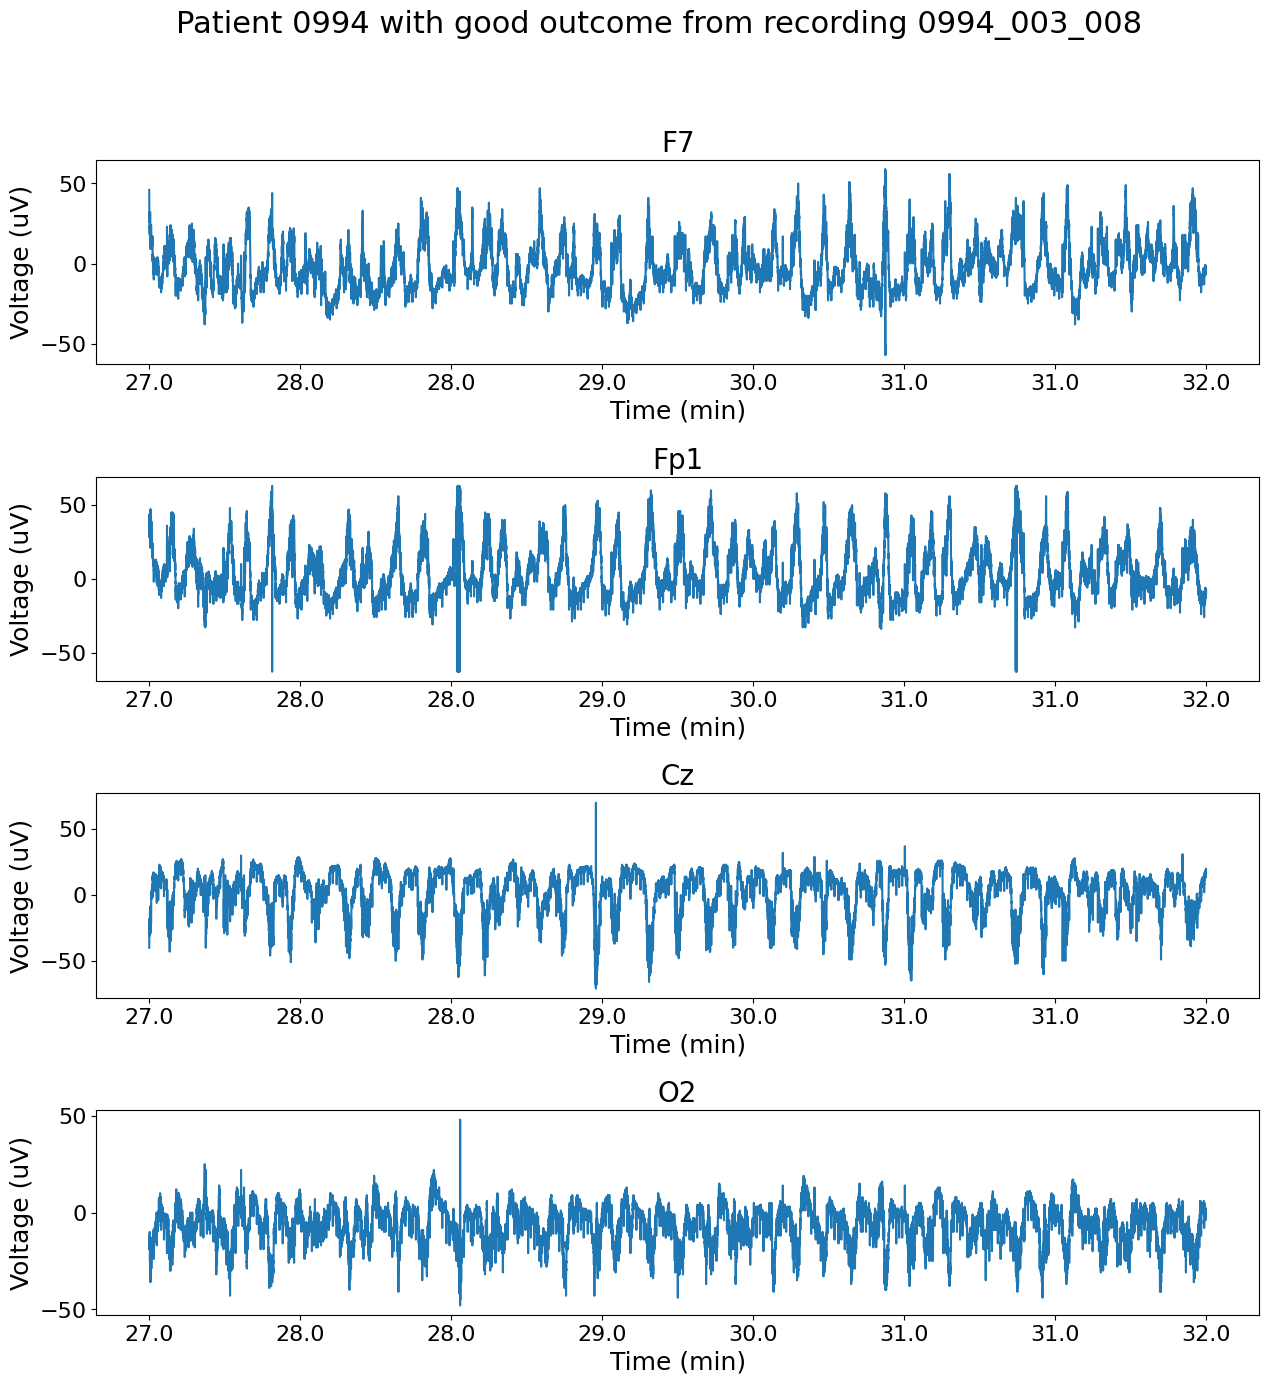

In [28]:
# Plot the random plots of the signals
num_tickets = 8
ticks = list(range(signal_start,signal_end))//(60*sampling_frequencies)
fig, axs = plt.subplots(channels_to_plot, 1, figsize=(15, 15))
for i in range(channels_to_plot):
    axs[i].plot(rand_signal_selection[i])
    axs[i].set_title(rand_channels[i], fontsize=20)
    axs[i].set_xlabel("Time (min)", fontsize=18)
    axs[i].set_ylabel("Voltage (uV)", fontsize=18)
    axs[i].tick_params(axis='both', which='major', labelsize=16)
    selected_labels = select_n_labels(ticks, num_tickets)
    selected_ticks = np.linspace(0, len(rand_signal_selection[i])-1, num_tickets, dtype=int)
    axs[i].set_xticks(selected_ticks)
    axs[i].set_xticklabels(selected_labels)
    plt.suptitle(f"Patient {example_patient_id} with good outcome from recording {example_recording_id}", fontsize=22)
    plt.subplots_adjust(hspace=0.55)
plt.savefig(output_dir + "recordings_example.pdf", format="pdf", bbox_inches="tight")
plt.show()

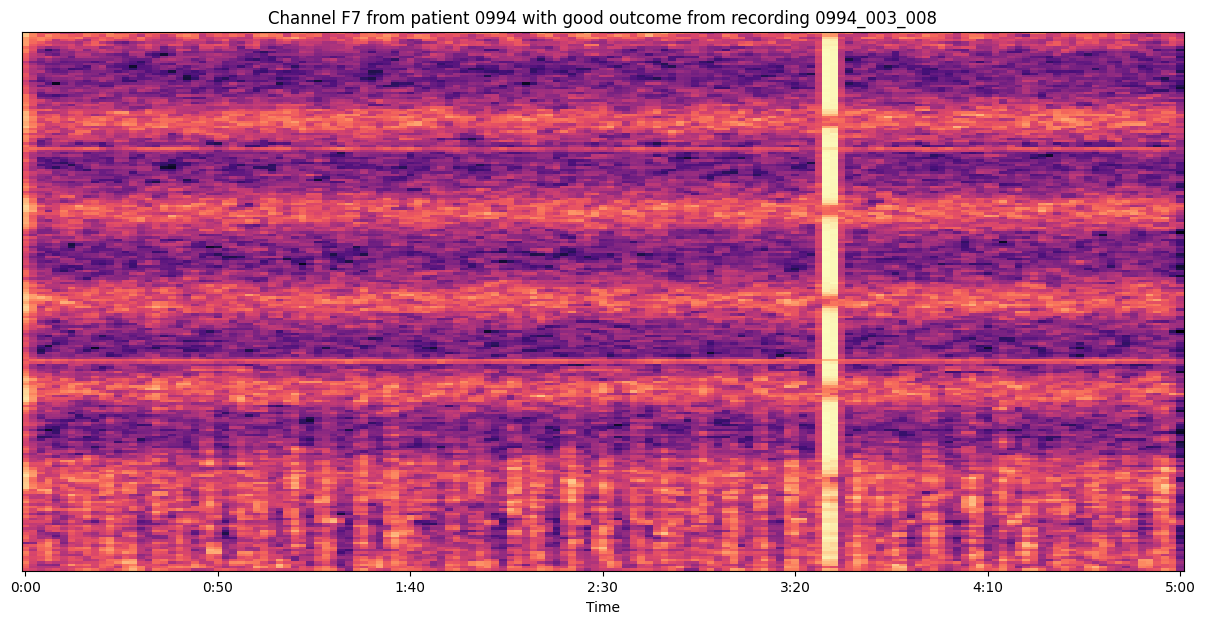

In [31]:
# Plot one of the signals with spectrogam
# Spectrograms
signal_data = rand_signal_selection[0]
channel = rand_channels[0]
spectrograms = librosa.feature.melspectrogram(y=signal_data, sr=sampling_frequencies, n_mels=224)
spectrograms = torch.from_numpy(spectrograms.astype(np.float32))
spectrograms = nn.functional.normalize(spectrograms)

fig, ax = plt.subplots( figsize=(15, 7))
S_dB = librosa.power_to_db(spectrograms, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', sr=sampling_frequencies, ax=ax)
ax.set(title=f"Channel {channel} from patient {example_patient_id} with good outcome from recording {example_recording_id}")

# Save as pdf
fig.savefig(f"{output_dir}spectrograms_example.pdf", bbox_inches='tight')

## 3.1 Old data prep

In [ ]:
# Filter data
df_plot_bad_quality = df_recordings_not_nan[df_recordings_not_nan["quality_score"]<0.1].iloc[42]
df_plot_good_quality = df_recordings_not_nan[df_recordings_not_nan["quality_score"]>0.99999].iloc[42]
good_patient_id = df_meta[df_meta["outcomes"]==0]["patient_id"].values[1]
bad_patient_id = df_meta[df_meta["outcomes"]==1]["patient_id"].values[1]

In [ ]:
# Convert times column to seconds since zero
df_recordings_not_nan["100Hz_seconds"] = df_recordings_not_nan["times"].apply(lambda x: (int(x.split(":")[0])*60*60 + int(x.split(":")[1])*60)*100)

# Get channels
channels = df_recordings_not_nan["channels"].values[0]

# Filter
df_plot_good = df_recordings_not_nan[df_recordings_not_nan.patient_id==good_patient_id]
df_plot_bad = df_recordings_not_nan[df_recordings_not_nan.patient_id==bad_patient_id]
df_plot_good_last_hour = df_plot_good.iloc[-1]
df_plot_bad_last_hour = df_plot_bad.iloc[-1]

# Prep
empty_signals_good = np.empty((18, 72*60*60*100))
empty_signals_bad = np.empty((18, 72*60*60*100))
for idx, c in enumerate(channels):
    for i, row in df_plot_good.iterrows():
        empty_signals_good[idx, row["100Hz_seconds"]:row["100Hz_seconds"]+row["signals"].shape[1]] = row["signals"][idx]
    for i, row in df_plot_bad.iterrows():
        empty_signals_bad[idx, row["100Hz_seconds"]:row["100Hz_seconds"]+row["signals"].shape[1]] = row["signals"][idx]

In [ ]:
# Count number of recordings per patient
df_aux = df_combined.groupby(['patient_id'])['hours'].count()
df_aux = df_aux.reset_index()
df_aux.columns = ['patient_id', 'num_recordings']
df_aux = df_aux.merge(df_meta[['patient_id', 'outcome_labels', 'cpcs', 'outcomes']], on="patient_id", how="left")

# Frequency histogram num_recordings including outcome_labels as color with alpha. Include option to set overall font size
plt.figure(figsize=(8, 5.5))
sns.histplot(data=df_aux, x="num_recordings", hue="outcome_labels", palette="Set2", alpha=0.5, stat="probability", bins=20)
plt.xlabel('num_recordings')
plt.ylabel('Frequency')
plt.show()

# T test with num_recordings and outcome_labels
df_aux_good = df_aux[df_aux["outcome_labels"] == "good"]
df_aux_poor = df_aux[df_aux["outcome_labels"] == "poor"]
print(ttest_ind(df_aux_good["num_recordings"], df_aux_poor["num_recordings"]))
print(np.mean(df_aux_good["num_recordings"]))
print(np.mean(df_aux_poor["num_recordings"]))

## 3.2 Old plots

In [ ]:
# Quality score
sns.histplot(data=df_recordings_not_nan, x="quality_score", bins=10, stat="frequency")

In [ ]:
# Max hours distribution
sns.histplot(df_combined.groupby(['patient_id'])['hours', 'outcomes'].max(), x="hours", hue="outcomes", bins=10, stat="frequency")

In [ ]:
# Over all hours
figure(figsize=(12, 8))
plt.plot(empty_signals_good[0, :], label=channels[0])
plt.title(f"Good outcome, patient {good_patient_id}")
plt.legend()
plt.show()

In [ ]:
# Last hour in one plot, good outcome
figure(figsize=(12, 8))
for idx, c in enumerate(df_plot_good_last_hour["channels_eeg"]):
    plt.plot(df_plot_good_last_hour["signals_eeg"][idx], label=c)
plt.title(f"Good outcome, patient {df_plot_good_last_hour['patient_id']} in hour {df_plot_good_last_hour['hours']}, quality {df_plot_good_last_hour['quality_score']}")
plt.legend()
plt.show()

In [ ]:
# Last hour in one plot, poor outcome
figure(figsize=(12, 8))
for idx, c in enumerate(df_plot_bad_last_hour["channels"]):
    plt.plot(df_plot_bad_last_hour["signals"][idx], label=c)
plt.title(f"Poor outcome, patient {df_plot_bad_last_hour['patient_id']} in hour {df_plot_bad_last_hour['hours']}, quality {df_plot_bad_last_hour['quality_score']}")
plt.legend()
plt.show()

In [ ]:
# Last hour in multiple plots, good outcome
fig, axs = plt.subplots(len(df_plot_good_last_hour["channels"]), 1, figsize=(15, 100))
for idx, c in enumerate(df_plot_good_last_hour["channels"][:18]):
    axs[idx].plot(df_plot_good_last_hour["signals"][idx], label=c)
    axs[idx].title.set_text(c)
fig.suptitle(f"Good outcome, patient {df_plot_good_last_hour['patient_id']} in hour {df_plot_good_last_hour['hours']}, quality {df_plot_good_last_hour['quality_score']}")
fig.tight_layout(pad=7)

In [ ]:
# Spectrograms
signal_data = df_plot_good_last_hour["signals"]
signal_data_lib = librosa.feature.melspectrogram(y=signal_data, sr=100, n_mels=224)
#signal_data_lib_num = torch.from_numpy(signal_data_lib)
#signal_data_lib_num = nn.functional.normalize(signal_data_lib_num)

fig, ax = plt.subplots( figsize=(15, 7))
S_dB = librosa.power_to_db(signal_data_lib[0], ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', sr=100, ax=ax)
ax.set(title=f'Mel-frequency spectrogram for {df_plot_good_last_hour["patient_id"]}, channel {df_plot_good_last_hour["channels"][0]}')

In [ ]:
# Last hour in multiple plots, poor outcome
fig, axs = plt.subplots(len(df_plot_bad_last_hour["channels"]), 1, figsize=(15, 70))
for idx, c in enumerate(df_plot_bad_last_hour["channels"][:18]):
    axs[idx].plot(df_plot_bad_last_hour["signals"][idx], label=c)
    axs[idx].title.set_text(c)
fig.suptitle(f"Bad outcome, patient {df_plot_bad_last_hour['patient_id']} in hour {df_plot_bad_last_hour['hours']}, quality {df_plot_bad_last_hour['quality_score']}")
fig.tight_layout(pad=7.0)

In [ ]:
# Good quality
figure(figsize=(12, 8))
for idx, c in enumerate(df_plot_good_quality["channels"]):
    plt.plot(df_plot_good_quality["signals"][idx], label=c)
plt.title(f"Good quality ({df_plot_good_quality['quality_score']}), patient {df_plot_good_quality['patient_id']} in hour {df_plot_good_quality['hours']}")
plt.legend()
plt.show()

In [ ]:
# Bad quality
figure(figsize=(12, 8))
for idx, c in enumerate(df_plot_bad_quality["channels"]):
    plt.plot(df_plot_bad_quality["signals"][idx], label=c)
plt.title(f"Bad quality ({df_plot_bad_quality['quality_score']}), patient {df_plot_bad_quality['patient_id']} in hour {df_plot_bad_quality['hours']}")
plt.legend()
plt.show()

_______________________

# 4. Summary analysis

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [57]:
file_path = "/Users/felixkrones/python_projects/data/physionet_challenge_2023/results.csv"
output_dir = "/Users/felixkrones/python_projects/data/physionet_challenge_2023/preprocessed_data/"

palette = "Set1"
label_font_size = 14
tick_font_size = 12

In [34]:
# Get recording information
df_rec = pd.read_csv(file_path)
df_rec = df_rec[df_rec["is_recording"]==1]
df_rec["outcome_labels"] = df_rec["outcome"].apply(lambda x: "poor" if x == 1 else "good")
df_EEG = df_rec[df_rec["EEG"]==1]
df_EEG_72 = df_EEG[df_EEG["Hours <= 72"]==1]
df_EEG.columns

# Get patient information
df_patients = df_EEG.groupby('Patient').first()

Index(['ID', 'File', 'Name', 'Type', 'EEG', 'ECG', 'Patient', 'hour_string',
       'hour', 'Hours <= 72', 'is_recording', 'outcome', 'cpc', 'hospital',
       'age', 'female', 'male', 'other', 'rosc', 'ohca', 'shockable_rhythm',
       'ttm', 'outcome_labels'],
      dtype='object')

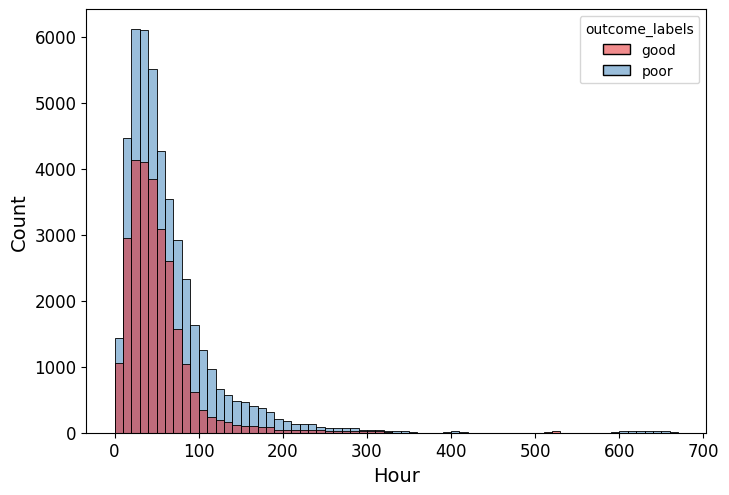

Ttest_indResult(statistic=-30.035026677806027, pvalue=5.62757560727807e-197)
Good mean: 50.98029739776952
Poor mean: 63.620694217792085


In [77]:
# EEG hours per outcome
df = df_EEG
x_variable = "hour"
hue_variable = "outcome_labels"
hue_0 = "good"
hue_1 = "poor"
stat="count"

plt.figure(figsize=(8, 5.5))
sns.histplot(data=df, x=x_variable, hue=hue_variable, palette=palette, alpha=0.5, stat=stat, bins=10, binwidth=10)
plt.xlabel(x_variable.capitalize(), fontsize=label_font_size)
plt.ylabel(stat.capitalize(), fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.savefig(output_dir + "eeg_hours_per_outcome.pdf", format="pdf", bbox_inches="tight")
plt.show()

# T test with num_recordings and outcome_labels
df_aux_good = df[df[hue_variable] == hue_0]
df_aux_poor = df[df[hue_variable] == hue_1]
print(ttest_ind(df_aux_good[x_variable], df_aux_poor[x_variable], nan_policy="omit"))
print(f"Good mean: {np.mean(df_aux_good[x_variable])}")
print(f"Poor mean: {np.mean(df_aux_poor[x_variable])}")

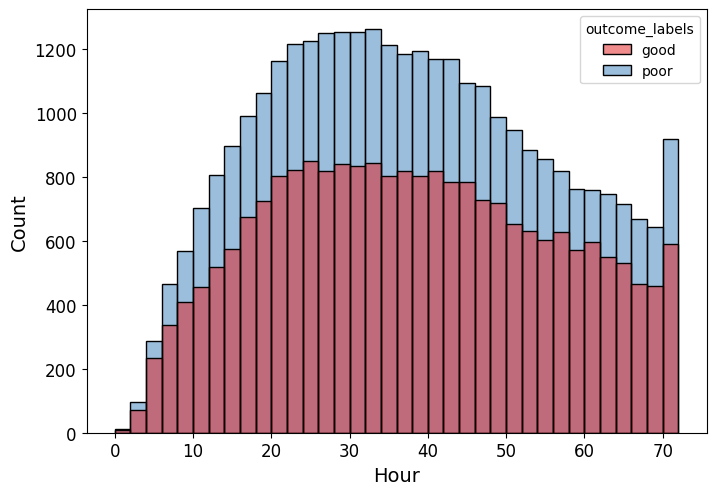

Ttest_indResult(statistic=2.2549719807335458, pvalue=0.024139024056786272)
Good mean: 37.610927300366626
Poor mean: 37.26526068402499


In [78]:
# EEG hours per outcome
df = df_EEG_72
x_variable = "hour"
hue_variable = "outcome_labels"
hue_0 = "good"
hue_1 = "poor"
stat="count"

plt.figure(figsize=(8, 5.5))
sns.histplot(data=df, x=x_variable, hue=hue_variable, palette=palette, alpha=0.5, stat=stat, bins=10, binwidth=2)
plt.xlabel(x_variable.capitalize(), fontsize=label_font_size)
plt.ylabel(stat.capitalize(), fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.savefig(output_dir + "eeg_hours_per_outcome_72.pdf", format="pdf", bbox_inches="tight")
plt.show()

# T test with num_recordings and outcome_labels
df_aux_good = df[df[hue_variable] == hue_0]
df_aux_poor = df[df[hue_variable] == hue_1]
print(ttest_ind(df_aux_good[x_variable], df_aux_poor[x_variable], nan_policy="omit"))
print(f"Good mean: {np.mean(df_aux_good[x_variable])}")
print(f"Poor mean: {np.mean(df_aux_poor[x_variable])}")

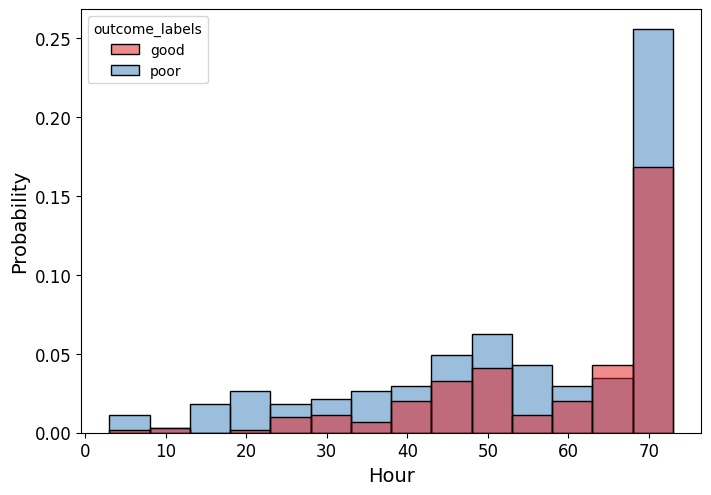

Ttest_indResult(statistic=3.096884915775841, pvalue=0.0020462017147714834)
Good mean: 58.973333333333336
Poor mean: 54.3717277486911


In [79]:
# EEG last hour per outcome
df = df_EEG_72[["Patient", "hour", "outcome_labels"]].groupby(["Patient"]).agg({'hour': 'max', 'outcome_labels': 'last'}).reset_index()
x_variable = "hour"
hue_variable = "outcome_labels"
hue_0 = "good"
hue_1 = "poor"
stat="probability"

plt.figure(figsize=(8, 5.5))
sns.histplot(data=df, x=x_variable, hue=hue_variable, palette=palette, alpha=0.5, stat=stat, bins=10, binwidth=5)
plt.xlabel(x_variable.capitalize(), fontsize=label_font_size)
plt.ylabel(stat.capitalize(), fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.savefig(output_dir + "eeg_last_hours_per_outcome.pdf", format="pdf", bbox_inches="tight")
plt.show()

# T test with num_recordings and outcome_labels
df_aux_good = df[df[hue_variable] == hue_0]
df_aux_poor = df[df[hue_variable] == hue_1]
print(ttest_ind(df_aux_good[x_variable], df_aux_poor[x_variable], nan_policy="omit"))
print(f"Good mean: {np.mean(df_aux_good[x_variable])}")
print(f"Poor mean: {np.mean(df_aux_poor[x_variable])}")

/var/folders/__/rxwd5ql13vz5lp1s1xlp8cg40000gn/T/ipykernel_13914/2884383883.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=x_variable, hue=hue_variable, color="black", palette=palette, alpha=0.5, stat=stat, bins=10, binwidth=5)


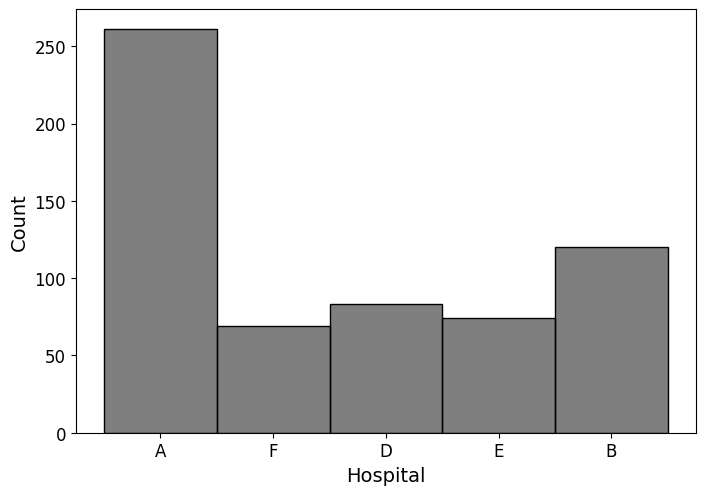

In [80]:
# Hospital per outcome
df = df_EEG_72[["Patient", "hospital", "outcome_labels"]].groupby(["Patient"]).agg({'hospital': 'last', 'outcome_labels': 'last'}).reset_index()
x_variable = "hospital"
hue_variable = None
hue_0 = "good"
hue_1 = "poor"
stat="count"

plt.figure(figsize=(8, 5.5))
sns.histplot(data=df, x=x_variable, hue=hue_variable, color="black", palette=palette, alpha=0.5, stat=stat, bins=10, binwidth=5)
plt.xlabel(x_variable.capitalize(), fontsize=label_font_size)
plt.ylabel(stat.capitalize(), fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.savefig(output_dir + "hospitals.pdf", format="pdf", bbox_inches="tight")
plt.show()

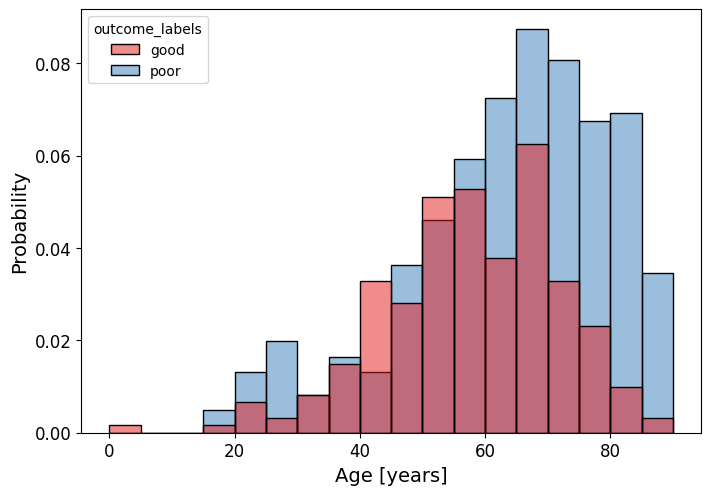

Ttest_indResult(statistic=-4.580937480609845, pvalue=5.623496915069892e-06)
Good mean: 57.29333333333334
Poor mean: 63.29057591623037


In [82]:
# Age outcome
df = df_patients
x_variable = "age"
hue_variable = "outcome_labels"
hue_0 = "good"
hue_1 = "poor"
stat="probability"

plt.figure(figsize=(8, 5.5))
sns.histplot(data=df, x=x_variable, hue=hue_variable, palette=palette, alpha=0.5, stat=stat, bins=10, binwidth=5)
plt.xlabel("Age [years]", fontsize=label_font_size)
plt.ylabel(stat.capitalize(), fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.savefig(output_dir + "age_hist.pdf", format="pdf", bbox_inches="tight")
plt.show()

# T test with num_recordings and outcome_labels
df_aux_good = df[df[hue_variable] == hue_0]
df_aux_poor = df[df[hue_variable] == hue_1]
print(ttest_ind(df_aux_good[x_variable], df_aux_poor[x_variable], nan_policy="omit"))
print(f"Good mean: {np.mean(df_aux_good[x_variable])}")
print(f"Poor mean: {np.mean(df_aux_poor[x_variable])}")

Number of patients with ROSC: 303 of 607


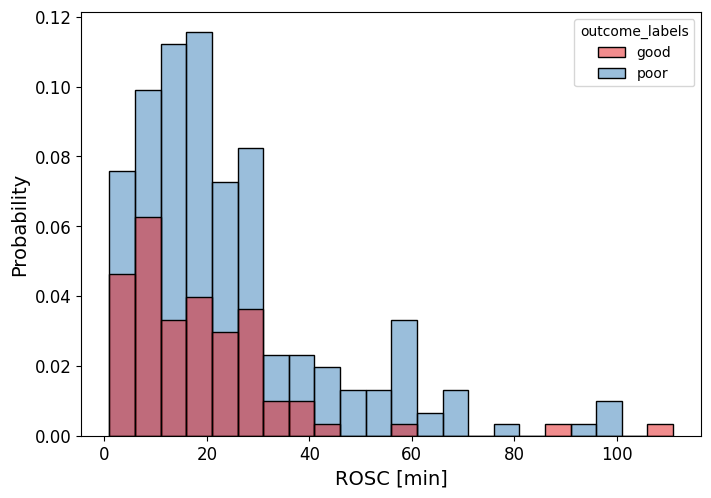

Ttest_indResult(statistic=-2.3213490913676966, pvalue=0.020935631028561646)
Good mean: 19.28235294117647
Poor mean: 24.821100917431192


In [83]:
# ROSC outcome
df = df_patients[df_patients["rosc"] >0]
print(f"Number of patients with ROSC: {len(df)} of {len(df_patients)}")
x_variable = "rosc"
hue_variable = "outcome_labels"
hue_0 = "good"
hue_1 = "poor"
stat="probability"

plt.figure(figsize=(8, 5.5))
sns.histplot(data=df, x=x_variable, hue=hue_variable, palette=palette, alpha=0.5, stat=stat, bins=10, binwidth=5)
plt.xlabel("ROSC [min]", fontsize=label_font_size)
plt.ylabel(stat.capitalize(), fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.savefig(output_dir + "rosc_scatter.pdf", format="pdf", bbox_inches="tight")
plt.show()

# T test with num_recordings and outcome_labels
df_aux_good = df[df[hue_variable] == hue_0]
df_aux_poor = df[df[hue_variable] == hue_1]
print(ttest_ind(df_aux_good[x_variable], df_aux_poor[x_variable], nan_policy="omit"))
print(f"Good mean: {np.mean(df_aux_good[x_variable])}")
print(f"Poor mean: {np.mean(df_aux_poor[x_variable])}")

In [64]:
len(df)

303